In [2]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import (
    precision_score, recall_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score
)
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [3]:
train_df = pd.read_parquet("../train_final_v3.parquet")
val_df = pd.read_parquet("../validationA_v3.parquet")
reviews_df = pd.read_pickle("../feature_extractions/reviews_raw.pkl")

In [4]:
print(train_df.shape)
print(val_df.shape)

(112768, 791)
(24164, 791)


In [5]:
X_train = train_df.drop(columns=['match'], axis=1)
X_val = val_df.drop(columns=['match'], axis=1)
y_train = train_df['match']
y_val = val_df['match']

In [6]:
X_val

,category,missing_price,item_rank,avg_rating,min_rating,percent_positive,percent_negative,avg_verified_reviewers,min_date,max_date,...,embedding_380,embedding_381,embedding_382,embedding_383,mean_sentiment_score,mean_complaint_similarity,mean_shipping_similarity,max_complaint_similarity,shipping_similarity_at_max_complaint,sentiment_score_at_max_complaint
328903,Sports & Outdoor Play,True,2261367.0,2.500000,4,0.500000,0.500000,1.000000,2014-02-15,2015-02-22,...,0.016948,-0.068813,-0.013661,0.101488,0.502364,0.135281,0.165143,0.195628,0.240833,0.005324
441635,Action Figures & Statues,True,541224.0,4.666667,5,1.000000,0.000000,1.000000,2016-12-25,2017-09-10,...,0.024212,0.010271,0.026576,0.056236,0.999246,0.056247,0.162368,0.135660,0.250080,0.999009
294770,Stuffed Animals & Plush Toys,False,1692453.0,1.000000,1,0.000000,1.000000,0.000000,2014-08-17,2014-08-17,...,0.034279,-0.071743,0.034022,0.143969,0.000270,0.203003,0.456016,0.203003,0.456016,0.000270
161637,Games,True,2187560.0,5.000000,5,1.000000,0.000000,1.000000,2011-07-17,2011-07-17,...,0.043803,-0.047145,-0.013756,0.120257,0.999848,0.118483,0.123220,0.118483,0.123220,0.999848
112229,Sports & Outdoor Play,True,2583901.0,5.000000,5,1.000000,0.000000,1.000000,2014-12-29,2014-12-29,...,0.023555,-0.021308,-0.010355,0.079722,0.999009,0.100356,0.161787,0.100356,0.161787,0.999009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520507,Baby & Toddler Toys,False,1069.0,4.518657,5,0.873134,0.074627,0.914179,2016-08-05,2018-09-13,...,-0.001130,-0.009788,0.021399,0.074541,0.868985,0.155356,0.218075,0.445087,0.287349,0.999855
523812,Dress Up & Pretend Play,False,139975.0,3.953488,5,0.674419,0.139535,0.930233,2016-12-22,2018-09-04,...,0.011493,0.027318,-0.016850,0.057224,0.779557,0.098794,0.190500,0.262011,0.509312,0.033752
536272,Toy Remote Control & Play Vehicles,False,71103.0,4.303030,5,0.818182,0.121212,1.000000,2017-01-06,2018-07-03,...,-0.011811,0.011275,-0.006499,0.060773,0.792642,0.065288,0.186122,0.335981,0.348223,0.999873
536984,"Tricycles, Scooters & Wagons",False,1318.0,3.850340,5,0.653061,0.224490,0.945578,2016-10-11,2018-09-26,...,-0.010304,0.029681,0.021493,0.050643,0.726797,0.093131,0.171684,0.290232,0.264554,0.009540


## Column Types

In [10]:
for df in (X_train, X_val):
    df['missing_price'] = df['missing_price'].astype(int)

print(f"The shape of X_train: {X_train.shape}, X_val: {X_val.shape}")

The shape of X_train: (112768, 789), X_val: (24164, 789)


In [11]:
for df in (X_train, X_val):
    df.drop(['percent_positive', 'percent_negative', 'unique_reviewer_count'], axis=1, inplace=True)

In [12]:
# STEP 1: Identify embedding columns separately
summary_embedding_cols = [col for col in X_train.columns if re.match(r'^embed_\d+$', col)]
review_embedding_cols = [col for col in X_train.columns if re.match(r'^embedding_\d+$', col)]

# Extract review and summary embedding subsets
X_emb_review_train = X_train[review_embedding_cols].copy()
X_emb_summary_train = X_train[summary_embedding_cols].copy()

X_emb_review_val = X_val[review_embedding_cols].copy()
X_emb_summary_val = X_val[summary_embedding_cols].copy()

# Drop all embedding columns from X_train and X_val
X_train_nonemb = X_train.drop(columns=review_embedding_cols + summary_embedding_cols)
X_val_nonemb   = X_val.drop(columns=review_embedding_cols + summary_embedding_cols)

# STEP 2: Preprocess non-embedding features
categorical_cols = ['category']  
numeric_cols = [col for col in X_train_nonemb.columns if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ]
)

X_train_nonemb_proc = preprocessor.fit_transform(X_train_nonemb)
X_val_nonemb_proc = preprocessor.transform(X_val_nonemb)

# STEP 3: Scale review and summary embeddings separately
scaler_review = StandardScaler()
X_emb_review_train_scaled = scaler_review.fit_transform(X_emb_review_train)
X_emb_review_val_scaled = scaler_review.transform(X_emb_review_val)

scaler_summary = StandardScaler()
X_emb_summary_train_scaled = scaler_summary.fit_transform(X_emb_summary_train)
X_emb_summary_val_scaled = scaler_summary.transform(X_emb_summary_val)

# STEP 4: PCA on each embedding type
pca_review = PCA(n_components=50, svd_solver='auto', random_state=42)
X_emb_review_train_reduced = pca_review.fit_transform(X_emb_review_train_scaled)
X_emb_review_val_reduced = pca_review.transform(X_emb_review_val_scaled)

pca_summary = PCA(n_components=10, svd_solver='auto', random_state=42)
X_emb_summary_train_reduced = pca_summary.fit_transform(X_emb_summary_train_scaled)
X_emb_summary_val_reduced = pca_summary.transform(X_emb_summary_val_scaled)

# STEP 5: VIF filtering
vif_feature_names = (
    numeric_cols +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
)
X_df_for_vif = pd.DataFrame(X_train_nonemb_proc, columns=vif_feature_names)

while True:
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_df_for_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_df_for_vif.values, i)
                       for i in range(X_df_for_vif.shape[1])]
    
    if vif_data["VIF"].max() <= 10:
        break

    drop_feature = vif_data.sort_values("VIF", ascending=False).iloc[0]["feature"]
    print(f"Dropping {drop_feature} with VIF = {vif_data['VIF'].max():.2f}")
    X_df_for_vif = X_df_for_vif.drop(columns=[drop_feature])

# Align validation with VIF-filtered features
X_val_nonemb_proc_df = pd.DataFrame(X_val_nonemb_proc, columns=vif_feature_names)
X_val_nonemb_filtered = X_val_nonemb_proc_df[X_df_for_vif.columns]

# STEP 6: Final feature names
final_feature_names = (
    X_df_for_vif.columns.tolist() +
    [f"pca_review_emb_{i}" for i in range(X_emb_review_train_reduced.shape[1])] +
    [f"pca_summary_emb_{i}" for i in range(X_emb_summary_train_reduced.shape[1])]
)

# STEP 7: Final data matrices
X_train_final_df = pd.DataFrame(
    np.hstack([X_df_for_vif.values, X_emb_review_train_reduced, X_emb_summary_train_reduced]),
    columns=final_feature_names
)

X_val_final_df = pd.DataFrame(
    np.hstack([X_val_nonemb_filtered.values, X_emb_review_val_reduced, X_emb_summary_val_reduced]),
    columns=final_feature_names
)


/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping review_span with VIF = inf


In [9]:
X_train_final_df1 = X_train_final_df
X_val_final_df1 = X_val_final_df

## Generate Feature Processor Class After Those Preprocessing Steps:

In [10]:
class FeatureProcessor:
    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

        self.preprocessor = None
        self.scaler_emb = None
        self.pca = None

        self.vif_keep_columns = None
        self.final_feature_names = None
        self.embedding_cols = None
        self.preproc_feature_names = None

    def _preprocess_dates_and_flags(self, df):
        df = df.copy()

        if 'max_date' in df.columns and 'min_date' in df.columns:
            df['review_span'] = (df['max_date'] - df['min_date']).dt.days
            df.drop(['min_date', 'max_date'], axis=1, inplace=True)

        if 'missing_price' in df.columns:
            df['missing_price'] = df['missing_price'].astype(int)

        if 'product_lifespan' in df.columns:
            df['product_lifespan_days'] = df['product_lifespan'].dt.days
            df.drop('product_lifespan', axis=1, inplace=True)

        drop_cols = [c for c in ['percent_positive', 'percent_negative', 'unique_reviewer_count'] if c in df.columns]
        df.drop(columns=drop_cols, errors='ignore', inplace=True)

        return df

    def fit(self, X_raw, skip_vif=False):
        X_raw = self._preprocess_dates_and_flags(X_raw)

        # Separate embeddings
        self.review_cols = [col for col in X_raw.columns if re.match(r'^embed_\d+$', col)]
        self.summary_cols = [col for col in X_raw.columns if re.match(r'^embedding_\d+$', col)]

        # Select columns for each embedding type
        X_emb_review = X_raw[self.review_cols]
        X_emb_summary = X_raw[self.summary_cols]
        X_emb = X_raw[self.review_cols + self.summary_cols]

        # Everything else
        X_nonemb = X_raw.drop(columns=self.review_cols + self.summary_cols)

        # Fit ColumnTransformer
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), self.numeric_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), self.categorical_cols),
            ]
        )
        X_nonemb_proc = self.preprocessor.fit_transform(X_nonemb)
        self.preproc_feature_names = (
            self.numeric_cols +
            list(self.preprocessor.named_transformers_['cat'].get_feature_names_out(self.categorical_cols))
        )

        # VIF filtering
        if not skip_vif:
            X_vif = pd.DataFrame(X_nonemb_proc, columns=self.preproc_feature_names)
            while True:
                vif_data = pd.DataFrame()
                vif_data["feature"] = X_vif.columns
                vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                                   for i in range(X_vif.shape[1])]
                if vif_data["VIF"].max() <= 10:
                    break
                drop_feature = vif_data.sort_values("VIF", ascending=False).iloc[0]["feature"]
                print(f"Dropping {drop_feature} with VIF = {vif_data['VIF'].max():.2f}")
                X_vif = X_vif.drop(columns=[drop_feature])
            self.vif_keep_columns = X_vif.columns.tolist()
        else:
            X_nonemb_df = pd.DataFrame(X_nonemb_proc, columns=self.preproc_feature_names)
            X_vif = X_nonemb_df[self.vif_keep_columns]

        # Scale and reduce embeddings
        self.scaler_emb = StandardScaler()
        X_emb_scaled = self.scaler_emb.fit_transform(X_emb)

        self.pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
        X_emb_reduced = self.pca.fit_transform(X_emb_scaled)

        # Final DataFrame
        self.final_feature_names = self.vif_keep_columns + [f'pca_emb_{i}' for i in range(X_emb_reduced.shape[1])]
        return pd.DataFrame(np.hstack([X_vif.values, X_emb_reduced]), columns=self.final_feature_names)

    def transform(self, X_raw):
        X_raw = self._preprocess_dates_and_flags(X_raw)

        # Separate embeddings
        self.embedding_cols = self.review_cols + self.summary_cols
        X_emb = X_raw[self.embedding_cols]
        X_nonemb = X_raw.drop(columns=self.embedding_cols)

        # Transform non-embedding
        X_nonemb_proc = self.preprocessor.transform(X_nonemb)
        X_nonemb_df = pd.DataFrame(X_nonemb_proc, columns=self.preproc_feature_names)
        X_vif = X_nonemb_df[self.vif_keep_columns]

        # Transform embeddings
        X_emb_scaled = self.scaler_emb.transform(X_emb)
        X_emb_reduced = self.pca.transform(X_emb_scaled)

        return pd.DataFrame(np.hstack([X_vif.values, X_emb_reduced]), columns=self.final_feature_names)

In [ ]:
class FeatureProcessor:
    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

        self.preprocessor = None

        self.scaler_review = None
        self.scaler_summary = None

        self.pca_review = None
        self.pca_summary = None

        self.vif_keep_columns = None
        self.final_feature_names = None

        self.review_cols = None
        self.summary_cols = None

        self.preproc_feature_names = None

    def _preprocess_dates_and_flags(self, df):
        df = df.copy()

        if 'max_date' in df.columns and 'min_date' in df.columns:
            df['review_span'] = (df['max_date'] - df['min_date']).dt.days
            df.drop(['min_date', 'max_date'], axis=1, inplace=True)

        if 'missing_price' in df.columns:
            df['missing_price'] = df['missing_price'].astype(int)

        if 'product_lifespan' in df.columns:
            df['product_lifespan_days'] = df['product_lifespan'].dt.days
            df.drop('product_lifespan', axis=1, inplace=True)

        drop_cols = [c for c in ['percent_positive', 'percent_negative', 'unique_reviewer_count'] if c in df.columns]
        df.drop(columns=drop_cols, errors='ignore', inplace=True)

        return df

    def fit(self, X_raw, skip_vif=False):
        X_raw = self._preprocess_dates_and_flags(X_raw)

        # Separate embedding columns
        self.review_cols = [col for col in X_raw.columns if re.match(r'^embed_\d+$', col)]
        self.summary_cols = [col for col in X_raw.columns if re.match(r'^embedding_\d+$', col)]

        # Extract embeddings separately
        X_emb_review = X_raw[self.review_cols]
        X_emb_summary = X_raw[self.summary_cols]

        # Non-embedding columns
        X_nonemb = X_raw.drop(columns=self.review_cols + self.summary_cols)

        # Fit ColumnTransformer on non-embedding features
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), self.numeric_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), self.categorical_cols),
            ]
        )
        X_nonemb_proc = self.preprocessor.fit_transform(X_nonemb)
        self.preproc_feature_names = (
            self.numeric_cols +
            list(self.preprocessor.named_transformers_['cat'].get_feature_names_out(self.categorical_cols))
        )

        # VIF filtering
        if not skip_vif:
            X_vif = pd.DataFrame(X_nonemb_proc, columns=self.preproc_feature_names)
            while True:
                vif_data = pd.DataFrame()
                vif_data["feature"] = X_vif.columns
                vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                                   for i in range(X_vif.shape[1])]
                if vif_data["VIF"].max() <= 10:
                    break
                drop_feature = vif_data.sort_values("VIF", ascending=False).iloc[0]["feature"]
                print(f"Dropping {drop_feature} with VIF = {vif_data['VIF'].max():.2f}")
                X_vif = X_vif.drop(columns=[drop_feature])
            self.vif_keep_columns = X_vif.columns.tolist()
        else:
            X_nonemb_df = pd.DataFrame(X_nonemb_proc, columns=self.preproc_feature_names)
            X_vif = X_nonemb_df[self.vif_keep_columns]

        # Scale embeddings separately
        self.scaler_review = StandardScaler()
        X_emb_review_scaled = self.scaler_review.fit_transform(X_emb_review)

        self.scaler_summary = StandardScaler()
        X_emb_summary_scaled = self.scaler_summary.fit_transform(X_emb_summary)

        # PCA separately
        self.pca_review = PCA(n_components=50, svd_solver='auto', random_state=42)
        X_emb_review_reduced = self.pca_review.fit_transform(X_emb_review_scaled)

        self.pca_summary = PCA(n_components=10, svd_solver='auto', random_state=42)
        X_emb_summary_reduced = self.pca_summary.fit_transform(X_emb_summary_scaled)

        # Compose final feature names with clear distinction
        self.final_feature_names = (
            self.vif_keep_columns +
            [f'pca_review_emb_{i}' for i in range(X_emb_review_reduced.shape[1])] +
            [f'pca_summary_emb_{i}' for i in range(X_emb_summary_reduced.shape[1])]
        )

        # Return combined DataFrame
        return pd.DataFrame(
            np.hstack([X_vif.values, X_emb_review_reduced, X_emb_summary_reduced]),
            columns=self.final_feature_names
        )

    def transform(self, X_raw):
        X_raw = self._preprocess_dates_and_flags(X_raw)

        # Separate embedding columns
        X_emb_review = X_raw[self.review_cols]
        X_emb_summary = X_raw[self.summary_cols]
        X_nonemb = X_raw.drop(columns=self.review_cols + self.summary_cols)

        # Transform non-embedding features
        X_nonemb_proc = self.preprocessor.transform(X_nonemb)
        X_nonemb_df = pd.DataFrame(X_nonemb_proc, columns=self.preproc_feature_names)
        X_vif = X_nonemb_df[self.vif_keep_columns]

        # Transform embeddings separately
        X_emb_review_scaled = self.scaler_review.transform(X_emb_review)
        X_emb_review_reduced = self.pca_review.transform(X_emb_review_scaled)

        X_emb_summary_scaled = self.scaler_summary.transform(X_emb_summary)
        X_emb_summary_reduced = self.pca_summary.transform(X_emb_summary_scaled)

        # Return combined DataFrame
        return pd.DataFrame(
            np.hstack([X_vif.values, X_emb_review_reduced, X_emb_summary_reduced]),
            columns=self.final_feature_names
        )


In [12]:
# Final vif columns
final_vif_columns = X_df_for_vif.columns.tolist()

print(f"Final vif columns: {final_vif_columns}")

processor = FeatureProcessor(numeric_cols, categorical_cols)
processor.vif_keep_columns = final_vif_columns

X_train_final_df = processor.fit(train_df.drop(columns=['match'], axis=1), skip_vif=True)
X_val_final_df   = processor.transform(val_df.drop(columns=['match'], axis=1))

Final vif columns: ['missing_price', 'item_rank', 'avg_rating', 'min_rating', 'avg_verified_reviewers', 'num_bots_per_asin', 'avg_reviews_per_day', 'reviews_per_product', 'avg_review_length_words', 'mean_sentiment_score', 'mean_complaint_similarity', 'mean_shipping_similarity', 'max_complaint_similarity', 'shipping_similarity_at_max_complaint', 'sentiment_score_at_max_complaint', 'product_lifespan_days', 'category_Action Figures & Statues', 'category_Arts & Crafts', 'category_Baby & Toddler Toys', 'category_Building Toys', 'category_Dolls & Accessories', 'category_Dress Up & Pretend Play', 'category_Games', 'category_Grown-Up Toys', 'category_Hobbies', "category_Kids' Electronics", "category_Kids' Furniture, Dcor & Storage", 'category_Learning & Education', 'category_Novelty & Gag Toys', 'category_Party Supplies', 'category_Puppets', 'category_Puzzles', 'category_Sports & Outdoor Play', 'category_Stuffed Animals & Plush Toys', 'category_Toy Remote Control & Play Vehicles', 'category_Tr

In [13]:
# Save preprocessed columns:
X_train_final_df.to_pickle("X_train_final_df.pkl")
X_val_final_df.to_pickle("X_val_final_df.pkl")

In [14]:
# Load preprocessed columns
X_train_final_df = pd.read_pickle("X_train_final_df.pkl")
X_val_final_df   = pd.read_pickle("X_val_final_df.pkl")

# Model Training

In [15]:
class ModelEvaluator:
    def __init__(self, model, average='binary', display_labels=None):
        self.model = model
        self.average = average
        self.display_labels = display_labels

    def evaluate_classification(self, y_true, y_pred):
        prec = precision_score(y_true, y_pred, average=self.average)
        rec  = recall_score   (y_true, y_pred, average=self.average)
        f1   = f1_score       (y_true, y_pred, average=self.average)

        print(f"Precision: {prec:.3f}")
        print(f"Recall:    {rec:.3f}")
        print(f"F1-score:  {f1:.3f}\n")

        print("Classification Report:\n", classification_report(y_true, y_pred))

        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=self.display_labels)
        fig, ax = plt.subplots(figsize=(5, 5))
        disp.plot(ax=ax, cmap='Blues')
        ax.set_title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, feature_names, top_n=30):
        if hasattr(self.model, "feature_importances_"):
            # Tree-based models
            importances = self.model.feature_importances_
            indices = importances.argsort()[::-1][:top_n]
    
            plt.figure(figsize=(10, 6))
            plt.barh(range(top_n), importances[indices][::-1])
            plt.yticks(range(top_n), [feature_names[i] for i in indices][::-1])
            plt.title("Top Feature Importances (Tree-based)")
            plt.tight_layout()
            plt.show()
    
        elif hasattr(self.model, "coef_"):
            # Linear models like Logistic Regression
            coefs = self.model.coef_.ravel()
            abs_coefs = np.abs(coefs)
            indices = abs_coefs.argsort()[::-1][:top_n]
    
            plt.figure(figsize=(10, 6))
            plt.barh(range(top_n), coefs[indices][::-1])
            plt.yticks(range(top_n), [feature_names[i] for i in indices][::-1])
            plt.title("Top Logistic Regression Coefficients")
            plt.axvline(0, color='black', linestyle='--', linewidth=0.7)
            plt.tight_layout()
            plt.show()
    
        else:
            print("This model does not support feature importance or coefficients.")



    def fit_and_evaluate(self, X_train, y_train, X_val, y_val):
        print("Training model:")
        self.model.fit(X_train, y_train)

        print("Training Performance:")
        y_train_pred = self.model.predict(X_train)
        self.evaluate_classification(y_train, y_train_pred)

        print("Validation Performance:")
        y_val_pred = self.model.predict(X_val)
        self.evaluate_classification(y_val, y_val_pred)

        return self.model


## Logistic Regression

Training model:
Training Performance:
Precision: 0.511
Recall:    0.776
F1-score:  0.459

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.87    112000
           1       0.02      0.78      0.05       768

    accuracy                           0.78    112768
   macro avg       0.51      0.78      0.46    112768
weighted avg       0.99      0.78      0.87    112768



/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


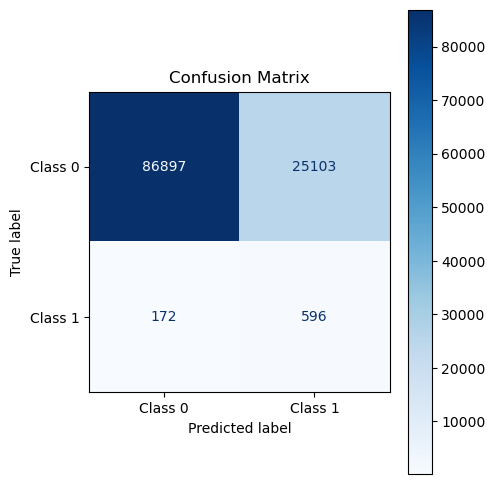

Validation Performance:
Precision: 0.509
Recall:    0.740
F1-score:  0.456

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87     24000
           1       0.02      0.71      0.04       164

    accuracy                           0.77     24164
   macro avg       0.51      0.74      0.46     24164
weighted avg       0.99      0.77      0.87     24164



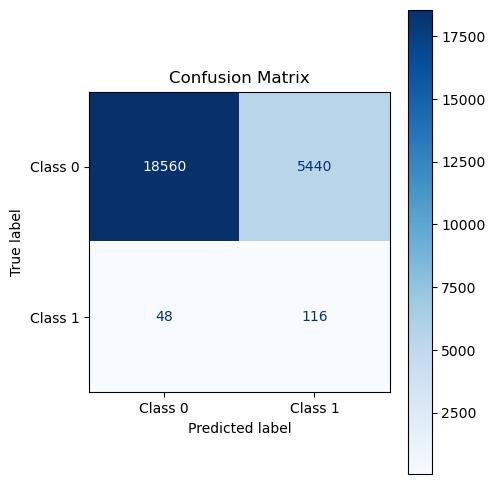

In [16]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='saga', penalty='l1', class_weight='balanced', random_state=42, max_iter=5000)

evaluator = ModelEvaluator(
    model=logreg,
    average='macro',   # or 'binary' for binary classification
    display_labels=['Class 0', 'Class 1']  # customize based on your labels
)

logreg = evaluator.fit_and_evaluate(X_train_final_df, y_train, X_val_final_df, y_val)

#evaluator.plot_feature_importance(final_feature_names)

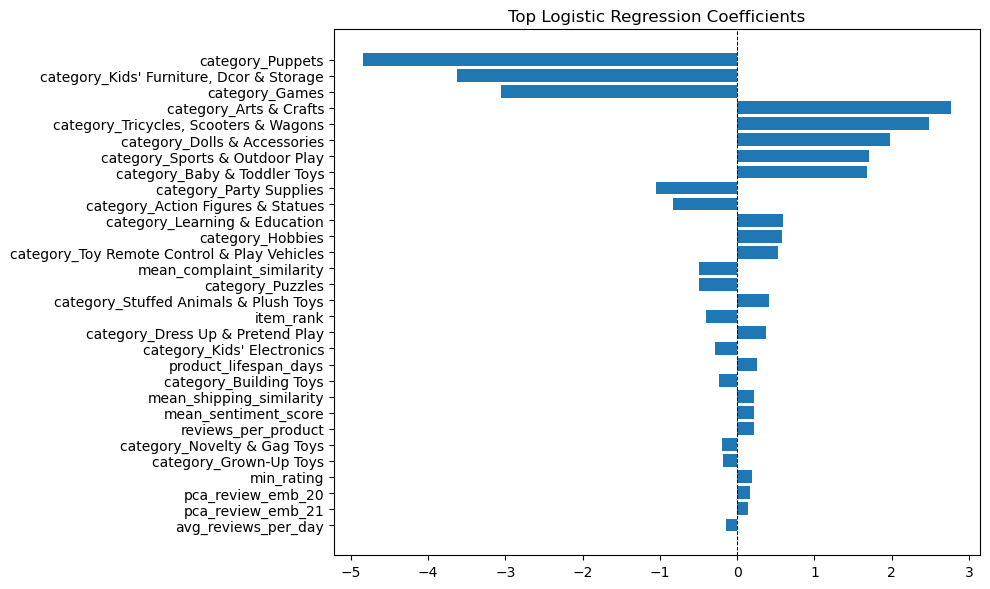

In [17]:
evaluator.plot_feature_importance(final_feature_names)

In [18]:
len(X_train_final_df.columns)

96

False Positive Analysis

In [19]:
def make_false_positive_df(X_validation_df, y_val, model, asin_file_path):
    """
    Creates a DataFrame of false positives (predicted 1 but true label is 0)
    from a classification model's validation predictions, merged with ASIN data.

    Parameters:
        X_validation_df (pd.DataFrame): Validation feature set.
        y_val (pd.Series): True labels with index corresponding to ASINs.
        model (sklearn-like model): Trained model with a `.predict()` method.
        asin_file_path (str): Path to a Parquet file containing ASIN metadata, indexed by ASIN.

    Returns:
        pd.DataFrame: False positive samples merged with ASIN metadata.
    """
    # Predict labels
    preds = model.predict(X_validation_df)
    probs = model.predict_proba(X_validation_df)[:,1]

    # Create DataFrame with predictions and true labels
    fp_df = X_validation_df.copy()
    fp_df['preds'] = preds
    fp_df['proba'] = probs
    fp_df['original_index'] = y_val.index
    fp_df['y_true'] = y_val.values

    # Load ASIN metadata
    asin_df = pd.read_parquet(asin_file_path)
    asin_df = asin_df.copy()
    asin_df['index'] = asin_df.index  # Preserve index for merging

    # Merge using the original indices (which should align with asin_df's index)
    fp_df = fp_df.merge(asin_df, left_on='original_index', right_on='index')

    # Filter to false positives only: true label 0, predicted 1
    false_positives = fp_df[(fp_df['y_true'] == 0) & (fp_df['preds'] == 1)]

    return false_positives, fp_df



In [20]:
false_positives, full_val_df = make_false_positive_df(X_val_final_df, y_val, logreg, '/Users/rebekaheichberg/Desktop/git-re/summer-2025-safeify/Data/asins_in_splits/validationA_asins.parquet')

In [ ]:

false_positives.sample(10)

,missing_price,item_rank,avg_rating,min_rating,avg_verified_reviewers,num_bots_per_asin,avg_reviews_per_day,reviews_per_product,avg_review_length_words,mean_sentiment_score,...,pca_summary_emb_6,pca_summary_emb_7,pca_summary_emb_8,pca_summary_emb_9,preds,proba,original_index,y_true,asin,index
11008,1.049033,0.039244,-0.173697,-0.662956,0.485576,-0.147503,-0.558417,-0.197906,0.074236,0.720015,...,0.331300,-6.270015,0.541198,-1.108871,1,0.653318,281984,0,B00CBNVSMI,281984
12423,-0.953258,-0.389284,0.790299,0.382759,0.485576,-0.147503,-0.217521,-0.139190,-0.538290,0.710537,...,1.832927,1.930919,-2.412299,-3.408467,1,0.624278,102958,0,B001U33QCU,102958
10556,1.049033,1.207285,0.790299,0.382759,0.485576,-0.147503,-0.523087,-0.197906,0.658707,0.684919,...,1.150743,-0.029128,1.488264,-2.431365,1,0.922897,231545,0,B00827RPIS,231545
14168,-0.953258,-0.186660,0.790299,0.382759,0.485576,-0.147503,0.084291,-0.197906,-0.697266,0.717107,...,0.494609,-0.347920,-1.248835,-0.092423,1,0.803059,526211,0,B01DLXFIO0,526211
13352,-0.953258,-0.871521,0.254746,0.382759,0.042451,-0.147503,-0.053577,-0.080473,-0.201115,0.357687,...,-3.253491,4.389601,-2.151624,-2.049290,1,0.594123,392471,0,B00NYAECES,392471
586,-0.953258,0.053937,0.790299,0.382759,0.485576,-0.147503,-0.509811,-0.183227,-0.463478,0.718573,...,2.840317,1.419811,-2.052890,-2.290417,1,0.549723,309627,0,B00EZ7UB7Q,309627
9715,-0.953258,-0.839705,-0.254030,0.382759,0.153232,-0.147503,0.084704,-0.036436,-0.087468,-0.393818,...,-1.765247,-1.717131,1.331079,2.013391,1,0.501640,424306,0,B00TF7ZMVG,424306
19823,1.049033,-1.165467,-0.220558,0.382759,0.236318,13.659235,0.095878,6.128769,-0.140341,-0.096359,...,0.073859,0.424323,0.441102,0.217506,1,0.683716,344707,0,B00IL795W8,344707
4607,-0.953258,-0.565711,-2.101687,-1.708671,0.485576,-0.147503,-0.538349,-0.183227,0.074236,-0.955941,...,-1.605833,-2.465888,-5.886446,-2.488247,1,0.609392,518784,0,B01CHXFZYI,518784
2056,-0.953258,-0.577431,0.790299,0.382759,0.485576,-0.147503,-0.559386,-0.183227,-0.498546,-0.652329,...,-3.318577,-3.796995,1.151716,-0.251970,1,0.954518,466171,0,B013F9LWAO,466171


In [29]:
# check review text of true negatives to see how negative words show up in the reviews
full_val_df[full_val_df['y_true']==0].sample(10)

,missing_price,item_rank,avg_rating,min_rating,avg_verified_reviewers,num_bots_per_asin,avg_reviews_per_day,reviews_per_product,avg_review_length_words,mean_sentiment_score,...,pca_summary_emb_6,pca_summary_emb_7,pca_summary_emb_8,pca_summary_emb_9,preds,proba,original_index,y_true,asin,index
4149,1.049033,-0.100214,0.597500,0.382759,0.485576,-0.147503,-0.166360,-0.139190,0.177103,0.358603,...,6.992036,-2.644622,-3.084836,-1.784005,0,0.097040,80652,0,B001BHV3D4,80652
20643,-0.953258,-0.506853,0.790299,0.382759,0.485576,3.304181,1.932897,-0.124511,0.144373,0.160895,...,6.346707,2.218868,-1.726664,-0.454706,0,0.025597,55358,0,B000UWH1MS,55358
22369,-0.953258,1.341244,0.790299,0.382759,0.485576,-0.147503,-0.528905,-0.197906,-0.790782,0.717107,...,1.288182,2.972365,-0.007132,1.795933,0,0.050010,394534,0,B00O6U40FQ,394534
6233,1.049033,2.020745,-1.137692,-1.708671,0.485576,-0.147503,0.084291,-0.197906,0.495055,-2.602504,...,0.232933,-2.219608,4.814337,8.899313,0,0.003725,274174,0,B00BPAM782,274174
11045,-0.953258,-1.184127,0.001379,0.382759,0.262026,-0.147503,0.065606,6.334276,0.113865,-0.172832,...,1.940663,-2.327450,-1.751622,0.971899,1,0.846833,254358,0,B00AAPHZVW,254358
14763,-0.953258,0.479972,-3.065682,-3.800100,-0.843799,-0.147503,0.084291,-0.168548,-0.268654,-1.564606,...,-2.875592,4.065381,-0.901993,-4.578063,0,0.361285,141871,0,B003W1GJV8,141871
10628,-0.953258,-1.159299,0.790299,0.382759,-0.312049,-0.147503,-0.350449,-0.139190,-0.239041,0.717928,...,2.365896,-4.602144,-2.223115,-1.190747,0,0.094955,303158,0,B00E9T9GG2,303158
8069,1.049033,1.303125,0.790299,0.382759,-3.502549,-0.147503,-0.557391,-0.197906,2.482258,0.719209,...,1.874776,1.647462,-0.884403,-2.052997,0,0.213436,259749,0,B00ASCJRNG,259749
6518,1.049033,0.484705,0.790299,0.382759,0.485576,-0.147503,0.084291,-0.197906,-0.744024,0.717107,...,1.245888,-9.109178,-3.543736,1.020258,0,0.020762,136907,0,B003KMN13S,136907
3007,1.049033,2.058734,-2.101687,-2.754386,0.485576,-0.147503,0.084291,-0.197906,0.191130,-2.594241,...,-3.929624,-1.295157,0.459115,1.128933,0,0.003720,119345,0,B002LZIHZW,119345


In [23]:
def false_positive_category_concentration(false_positive_df):
    dummies = list(false_positive_df.columns[:-2])
    un_dummied = false_positive_df[dummies].idxmax(axis=1)
    un_dummied = un_dummied.str.replace('cat_', '', regex=False)
    return un_dummied.value_counts(normalize=True)
    

In [24]:
def false_positive_category_concentration(false_positive_df, dummy_prefix='category_'):
    """
    Calculates the normalized concentration of false positives across categories.

    Parameters:
        false_positive_df (pd.DataFrame): DataFrame of false positives with one-hot encoded category columns.
        dummy_prefix (str): Prefix used in the one-hot encoded category column names (default is 'cat_').

    Returns:
        pd.Series: Normalized value counts (proportions) for each original category.
    """
    # Automatically detect one-hot encoded category columns
    category_cols = [col for col in false_positive_df.columns if col.startswith(dummy_prefix)]

    if not category_cols:
        raise ValueError(f"No columns found with prefix '{dummy_prefix}'.")

    # Get the most likely category per row (based on the dummy with max value)
    top_category = false_positive_df[category_cols].idxmax(axis=1)

    # Remove prefix to get original category names
    top_category = top_category.str.replace(dummy_prefix, '', regex=False)

    # Return normalized frequency
    return top_category.value_counts(normalize=True)


In [25]:
false_positive_category_concentration(false_positives)

Dolls & Accessories                   0.204412
Arts & Crafts                         0.152390
Sports & Outdoor Play                 0.111397
Toy Remote Control & Play Vehicles    0.086765
Stuffed Animals & Plush Toys          0.081801
Baby & Toddler Toys                   0.059007
Learning & Education                  0.057537
Hobbies                               0.049632
Dress Up & Pretend Play               0.038787
Action Figures & Statues              0.036029
Building Toys                         0.032904
Novelty & Gag Toys                    0.024632
Kids' Electronics                     0.021691
Tricycles, Scooters & Wagons          0.020404
Puzzles                               0.010294
Grown-Up Toys                         0.005515
Party Supplies                        0.004228
Games                                 0.002574
Name: proportion, dtype: float64

<Axes: title={'center': 'Category Distribution: False Positives vs True Negatives'}>

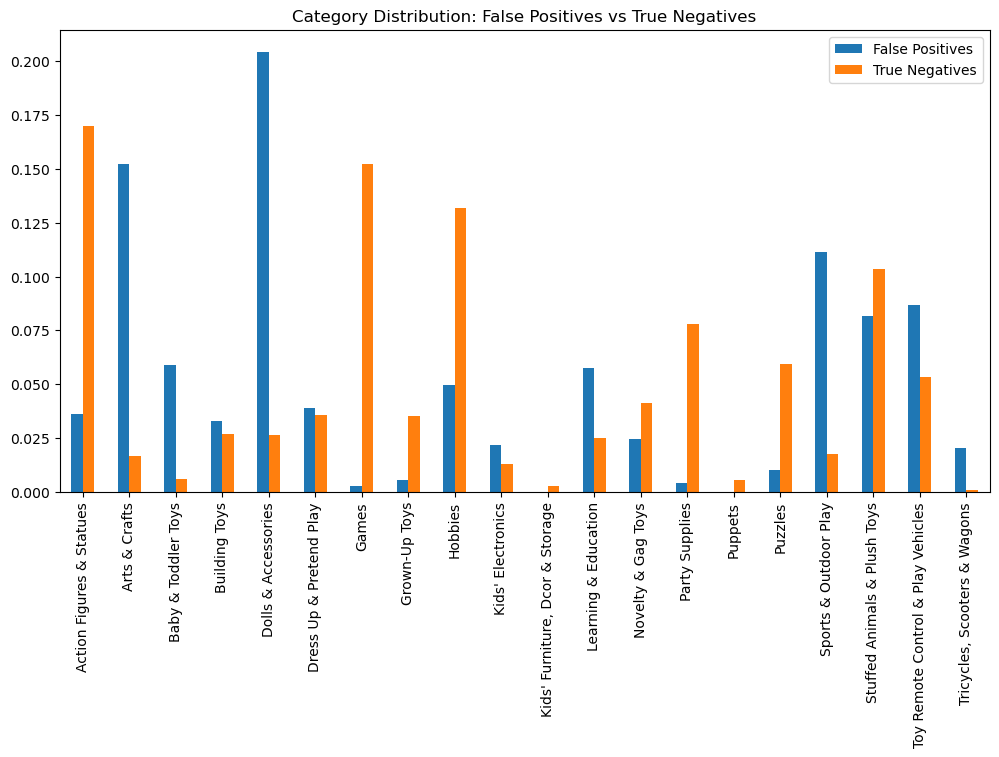

In [26]:
# Get normalized counts for each category in false positives
fp_cat_dist = false_positive_category_concentration(false_positives)

# Do the same for true negatives (TN): y_true = 0, preds = 0
tn_df = full_val_df[(full_val_df['y_true'] == 0) & (full_val_df['preds'] == 0)]
tn_cat_dist = false_positive_category_concentration(tn_df)

# Combine into a DataFrame for plotting
comparison_df = pd.DataFrame({
    'False Positives': fp_cat_dist,
    'True Negatives': tn_cat_dist
}).fillna(0)

# Plot
comparison_df.plot(kind='bar', figsize=(12,6), title='Category Distribution: False Positives vs True Negatives')


You're already computing the normalized distribution of false positives across categories, but you can expand it by comparing it to the distribution in the overall dataset or true negatives, and use statistical tests to see if the difference is significant.

In [38]:
from scipy.stats import chi2_contingency

def compute_category_chi2(fp_df, tn_df, dummy_prefix='cat_'):
    # Step 1: Get category columns
    cat_cols = [col for col in fp_df.columns if col.startswith(dummy_prefix)]
    
    # Step 2: Convert back to category labels
    def get_cat_dist(df):
        cat_labels = df[cat_cols].idxmax(axis=1).str.replace(dummy_prefix, '', regex=False)
        return cat_labels.value_counts()
    
    fp_counts = get_cat_dist(fp_df)
    tn_counts = get_cat_dist(tn_df)

    # Step 3: Align index and fill missing categories with 0
    aligned = pd.concat([fp_counts, tn_counts], axis=1, keys=['FP', 'TN']).fillna(0)

    # Step 4: Ensure integer values
    aligned = aligned.astype(int)

    # Step 5: Create contingency table
    contingency = aligned.T.values

    # Step 6: Perform Chi-squared test
    chi2, p, _, _ = chi2_contingency(contingency)

    return p, aligned


In [39]:
p, cat_table = compute_category_chi2(false_positives, tn_df, dummy_prefix='category_')

In [40]:
p

np.float64(0.0)

* Your model is **systematically misclassifying certain categories** as positive, even though they’re actually negative.
* Some categories are **overrepresented** in the false positives relative to the true negatives.
* This is a red flag that may indicate:

  * **Feature bias**: Certain features correlate with these categories and are driving the wrong predictions.
  * **Label issues**: These categories may be ambiguous or inconsistently labeled.
  * **Insufficient representation** in training data for those categories.

In [41]:
cat_table

,FP,TN
Dolls & Accessories,1112,486
Arts & Crafts,829,307
Sports & Outdoor Play,606,324
Toy Remote Control & Play Vehicles,472,991
Stuffed Animals & Plush Toys,445,1917
Baby & Toddler Toys,321,113
Learning & Education,313,463
Hobbies,270,2448
Dress Up & Pretend Play,211,660
Action Figures & Statues,196,3151


In [42]:
cat_table['FP_Rate'] = cat_table['FP'] / cat_table['FP'].sum()
cat_table['TN_Rate'] = cat_table['TN'] / cat_table['TN'].sum()
cat_table['Overrepresented_in_FP'] = cat_table['FP_Rate'] - cat_table['TN_Rate']
cat_table.sort_values('Overrepresented_in_FP', ascending=False).head(10)


,FP,TN,FP_Rate,TN_Rate,Overrepresented_in_FP
Dolls & Accessories,1112,486,0.204412,0.026185,0.178226
Arts & Crafts,829,307,0.152390,0.016541,0.135849
Sports & Outdoor Play,606,324,0.111397,0.017457,0.093940
Baby & Toddler Toys,321,113,0.059007,0.006088,0.052919
Toy Remote Control & Play Vehicles,472,991,0.086765,0.053394,0.033370
Learning & Education,313,463,0.057537,0.024946,0.032591
"Tricycles, Scooters & Wagons",111,18,0.020404,0.000970,0.019435
Kids' Electronics,118,241,0.021691,0.012985,0.008706
Building Toys,179,498,0.032904,0.026832,0.006073
Dress Up & Pretend Play,211,660,0.038787,0.035560,0.003226


Text(0, 0.5, 'Normalized Rate')

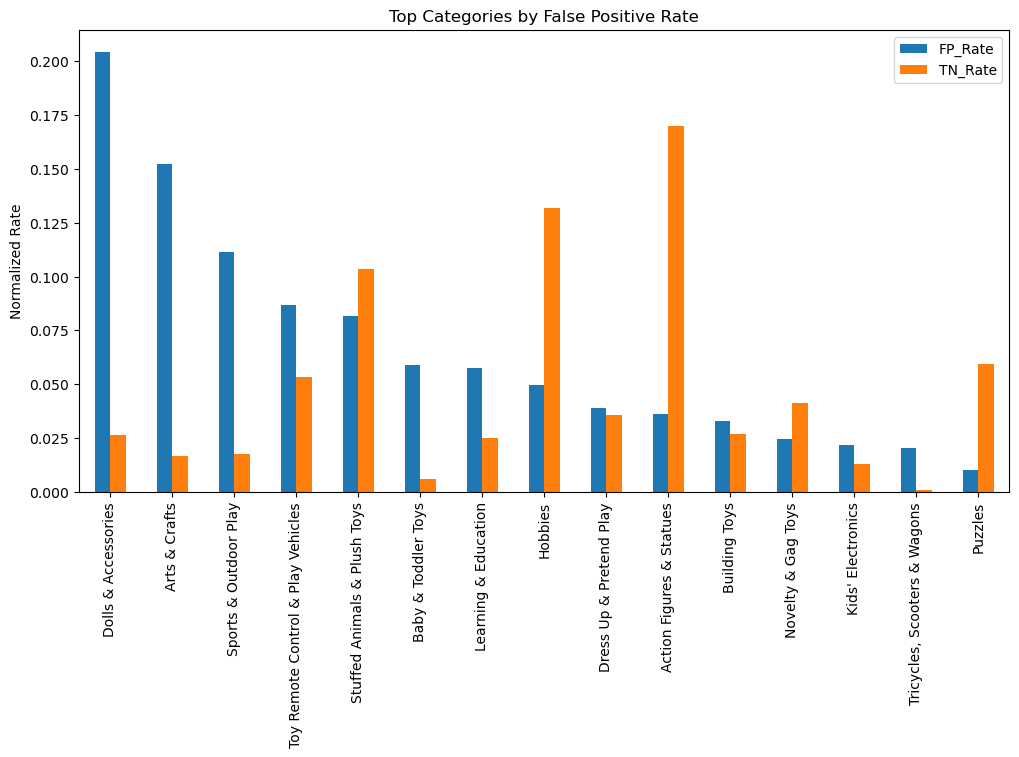

In [43]:
import matplotlib.pyplot as plt

cat_table[['FP_Rate', 'TN_Rate']].sort_values('FP_Rate', ascending=False).head(15).plot(
    kind='bar', figsize=(12, 6), title='Top Categories by False Positive Rate'
)
plt.ylabel('Normalized Rate')


False positives with high predicted probabilities could indicate:

- Confusing features
- Potential label noise
- Overconfident model predictions

Text(0, 0.5, 'Count')

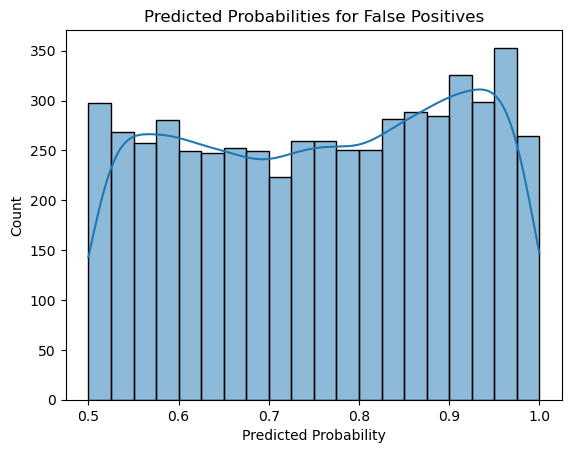

In [44]:
# Histogram of probabilities
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(false_positives['proba'], bins=20, kde=True)
plt.title("Predicted Probabilities for False Positives")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")


1. High Model Confidence in False Positives
A large number of false positives have probabilities > 0.9
This suggests the model is often very confident about its incorrect predictions
These are not borderline mistakes — the model is misled confidently
2. Potential Causes
Some features (or categories) are strongly associated with the positive class, but appear in the negative samples
Label noise: Some of these false positives might actually be true positives incorrectly labeled as 0
Spurious correlations: Your model might be learning non-generalizable patterns (e.g., text keywords, rare categories)

Text(0.5, 1.0, 'Calibration Curve for False Positives')

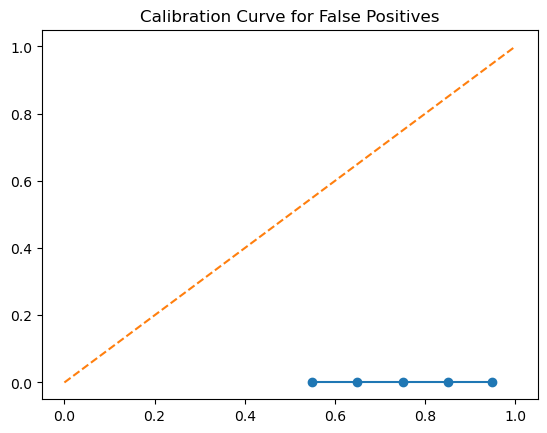

In [45]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(false_positives['y_true'], false_positives['proba'], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("Calibration Curve for False Positives")


Your model is overconfident in its false positives.
It assigns high probabilities to many negative examples that it mistakenly classifies as positive.
From the model's perspective, these are “slam-dunks” — but it’s badly wrong.

With Dolls and Accessories Category

Training model:
Training Performance:
Precision: 0.512
Recall:    0.803
F1-score:  0.464

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.88    112000
           1       0.03      0.82      0.05       768

    accuracy                           0.79    112768
   macro avg       0.51      0.80      0.46    112768
weighted avg       0.99      0.79      0.87    112768



/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


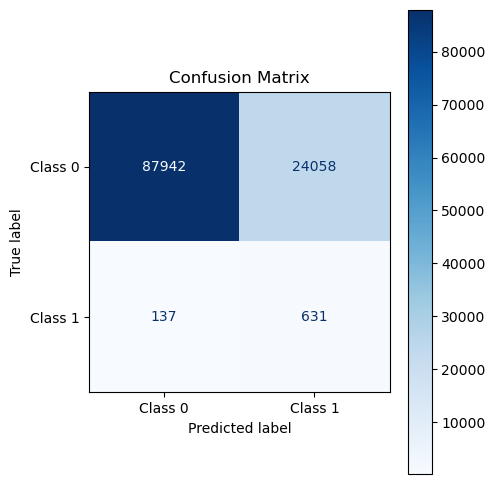

Validation Performance:
Precision: 0.510
Recall:    0.761
F1-score:  0.461

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.88     24000
           1       0.02      0.74      0.04       164

    accuracy                           0.78     24164
   macro avg       0.51      0.76      0.46     24164
weighted avg       0.99      0.78      0.87     24164



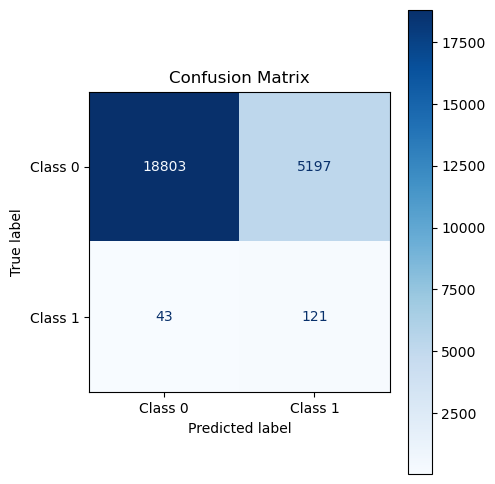

In [46]:
logreg = LogisticRegression(solver='saga', penalty='l1',class_weight='balanced', random_state=42)

evaluator = ModelEvaluator(
    model=logreg,
    average='macro',   # or 'binary' for binary classification
    display_labels=['Class 0', 'Class 1']  # customize based on your labels
)

logreg = evaluator.fit_and_evaluate(X_train_final_df, y_train, X_val_final_df, y_val)

Remove Dolls and Accessories Category

In [47]:
mod_X_train_df = X_train_final_df.drop(columns=['category_Dolls & Accessories'])
mod_X_val_df = X_val_final_df.drop(columns=['category_Dolls & Accessories'])


Training model:
Training Performance:
Precision: 0.511
Recall:    0.785
F1-score:  0.463

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.88    112000
           1       0.02      0.78      0.05       768

    accuracy                           0.79    112768
   macro avg       0.51      0.78      0.46    112768
weighted avg       0.99      0.79      0.87    112768



/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


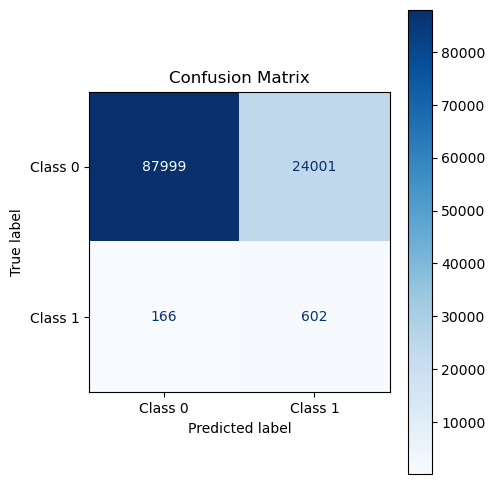

Validation Performance:
Precision: 0.510
Recall:    0.752
F1-score:  0.461

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.88     24000
           1       0.02      0.72      0.04       164

    accuracy                           0.78     24164
   macro avg       0.51      0.75      0.46     24164
weighted avg       0.99      0.78      0.87     24164



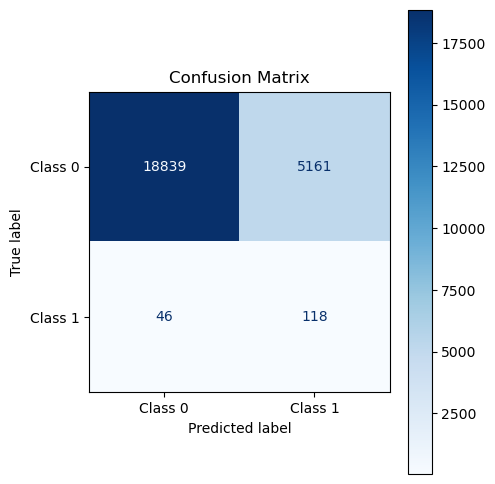

In [48]:
logreg = LogisticRegression(solver='saga', penalty='l1', class_weight='balanced', random_state=42, max_iter=5000)

evaluator = ModelEvaluator(
    model=logreg,
    average='macro',   # or 'binary' for binary classification
    display_labels=['Class 0', 'Class 1']  # customize based on your labels
)

logreg = evaluator.fit_and_evaluate(mod_X_train_df, y_train, mod_X_val_df, y_val)

Feature Selection

In [49]:
import sys
sys.path.insert(0, '../Data/')
from get_cv_split import PredefinedKFold
split_data=pd.read_parquet("../Data/CV_val_split.parquet")
assert((split_data.index==X_train.index).all()) # Sanity check to verify indices of X_train match up with indices of split_data
kfold=PredefinedKFold(split_data)

In [50]:
review_embed_cols = [col for col in X_train_final_df.columns if col.startswith('pca_review_emb_')]
summary_embed_cols = [col for col in X_train_final_df.columns if col.startswith('pca_summary_emb_')]

In [51]:
X_train_review = X_train_final_df.drop(columns = review_embed_cols)
X_val_review = X_val_final_df.drop(columns = review_embed_cols)

X_train_sum = X_train_final_df.drop(columns = summary_embed_cols)
X_val_sum = X_val_final_df.drop(columns = summary_embed_cols)

Review Only

Training model:
Training Performance:
Precision: 0.512
Recall:    0.809
F1-score:  0.465

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.88    112000
           1       0.03      0.83      0.05       768

    accuracy                           0.79    112768
   macro avg       0.51      0.81      0.46    112768
weighted avg       0.99      0.79      0.87    112768



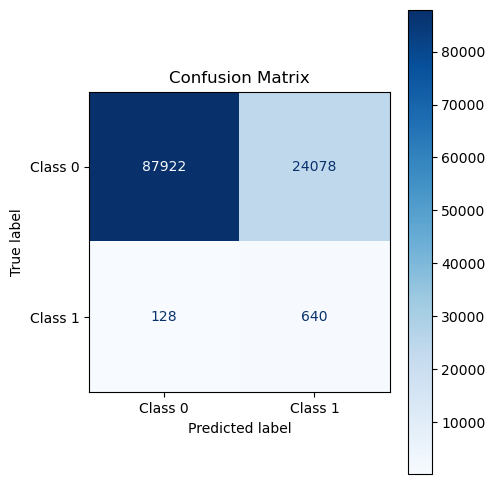

Validation Performance:
Precision: 0.512
Recall:    0.801
F1-score:  0.464

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.88     24000
           1       0.03      0.82      0.05       164

    accuracy                           0.78     24164
   macro avg       0.51      0.80      0.46     24164
weighted avg       0.99      0.78      0.87     24164



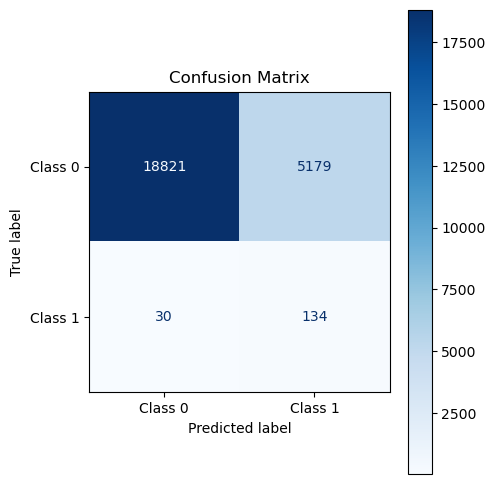

In [52]:
logreg = LogisticRegression(solver='saga', penalty='l1', class_weight='balanced', random_state=42, max_iter=5000)

evaluator = ModelEvaluator(
    model=logreg,
    average='macro',   # or 'binary' for binary classification
    display_labels=['Class 0', 'Class 1']  # customize based on your labels
)

logreg = evaluator.fit_and_evaluate(X_train_review, y_train, X_val_review, y_val)


Test CV Splits

Training model:
Training Performance:
Precision: 0.512
Recall:    0.809
F1-score:  0.465

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.88    112000
           1       0.03      0.83      0.05       768

    accuracy                           0.79    112768
   macro avg       0.51      0.81      0.46    112768
weighted avg       0.99      0.79      0.87    112768



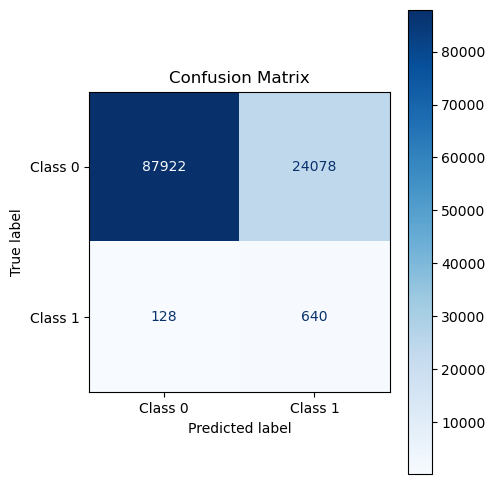

Validation Performance:
Precision: 0.512
Recall:    0.801
F1-score:  0.464

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.88     24000
           1       0.03      0.82      0.05       164

    accuracy                           0.78     24164
   macro avg       0.51      0.80      0.46     24164
weighted avg       0.99      0.78      0.87     24164



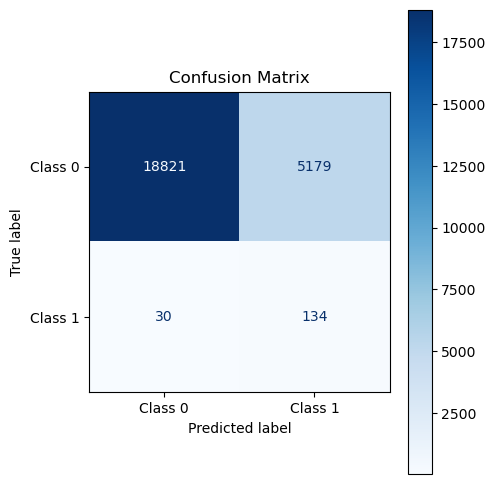

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression(solver='saga', penalty='l1',class_weight='balanced', random_state=42, max_iter=5000)

evaluator = ModelEvaluator(
    model=logreg,
    average='macro',   # or 'binary' for binary classification
    display_labels=['Class 0', 'Class 1']  # customize based on your labels
)

logreg = evaluator.fit_and_evaluate(X_train_review, y_train, X_val_review, y_val)

In [54]:
scores_review_only_macro = cross_val_score(logreg, X_train_review, y_train, cv=kfold, scoring='recall_macro')
scores_review_only_acc = cross_val_score(logreg, X_train_review, y_train, cv=kfold, scoring='accuracy')
scores_review_only_f1 = cross_val_score(logreg, X_train_review, y_train, cv=kfold, scoring='f1_macro')

/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: C

In [55]:
print(f'CV scores on review only are:')
print(f'recall:{np.mean(scores_review_only_macro)}')
print(f'acc:{np.mean(scores_review_only_acc)}')
print(f'f1:{np.mean(scores_review_only_f1)}')

CV scores on review only are:
recall:0.6293650054680937
acc:0.8013251963750481
f1:0.46049064303648685


Summary Only

Training model:
Training Performance:
Precision: 0.511
Recall:    0.795
F1-score:  0.460

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.87    112000
           1       0.02      0.81      0.05       768

    accuracy                           0.78    112768
   macro avg       0.51      0.79      0.46    112768
weighted avg       0.99      0.78      0.87    112768



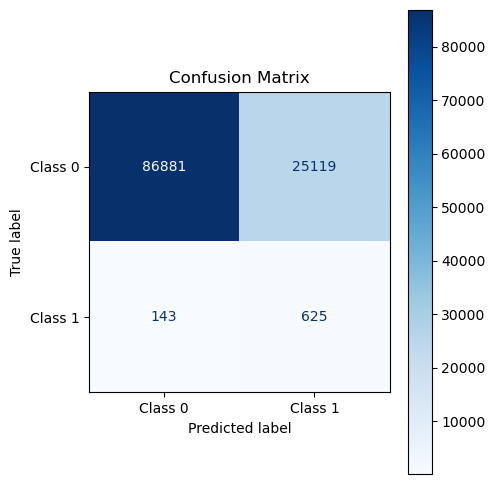

Validation Performance:
Precision: 0.509
Recall:    0.737
F1-score:  0.455

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87     24000
           1       0.02      0.70      0.04       164

    accuracy                           0.77     24164
   macro avg       0.51      0.74      0.46     24164
weighted avg       0.99      0.77      0.86     24164



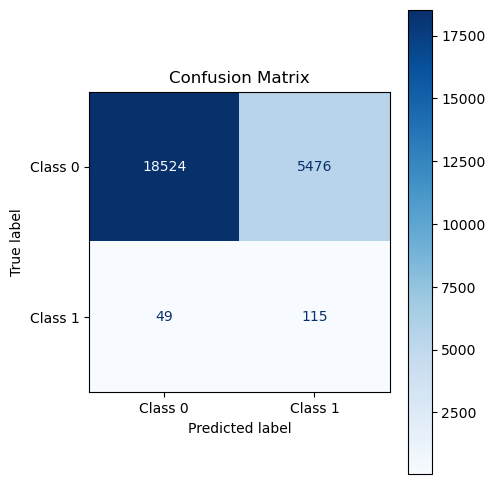

In [ ]:
logreg = LogisticRegression(msolver='saga', penalty='l1',class_weight='balanced', random_state=42, max_iter=1000)

evaluator = ModelEvaluator(
    model=logreg,
    average='macro',   # or 'binary' for binary classification
    display_labels=['Class 0', 'Class 1']  # customize based on your labels
)

logreg = evaluator.fit_and_evaluate(X_train_sum, y_train, X_val_sum, y_val)

In [34]:
scores_sum_only_macro = cross_val_score(logreg, X_train_sum, y_train, cv=kfold, scoring='recall_macro')
scores_sum_only_acc = cross_val_score(logreg, X_train_sum, y_train, cv=kfold, scoring='accuracy')
scores_sum_only_f1 = cross_val_score(logreg, X_train_sum, y_train, cv=kfold, scoring='f1_macro')

In [36]:
print(f'CV scores on summary only are:')
print(f'recall:{np.mean(scores_sum_only_macro)}')
print(f'acc:{np.mean(scores_sum_only_acc)}')
print(f'f1:{np.mean(scores_sum_only_f1)}')

CV scores on summary only are:
recall:0.6136843752519745
acc:0.7945566412772568
f1:0.45703901731273106


Non Embedding Cols

In [42]:
excluded_cols = summary_embed_cols + review_embed_cols
remaining_cols = [col for col in X_train_final_df.columns if col not in excluded_cols]

In [43]:
X_non_embed_train = X_train_final_df[remaining_cols]
X_non_embed_val = X_val_final_df[remaining_cols]

Training model:
Training Performance:
Precision: 0.510
Recall:    0.780
F1-score:  0.454

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.76      0.86    112000
           1       0.02      0.80      0.04       768

    accuracy                           0.76    112768
   macro avg       0.51      0.78      0.45    112768
weighted avg       0.99      0.76      0.86    112768



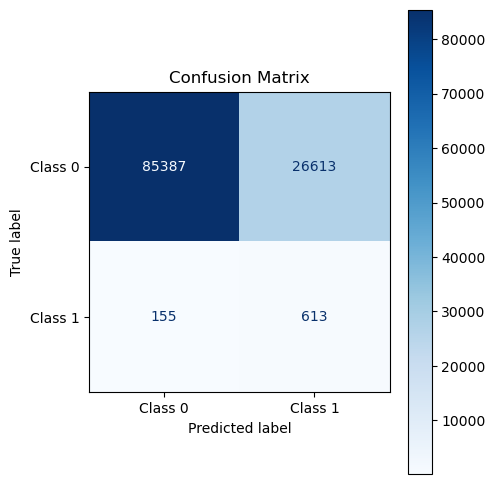

Validation Performance:
Precision: 0.509
Recall:    0.752
F1-score:  0.452

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.76      0.86     24000
           1       0.02      0.74      0.04       164

    accuracy                           0.76     24164
   macro avg       0.51      0.75      0.45     24164
weighted avg       0.99      0.76      0.86     24164



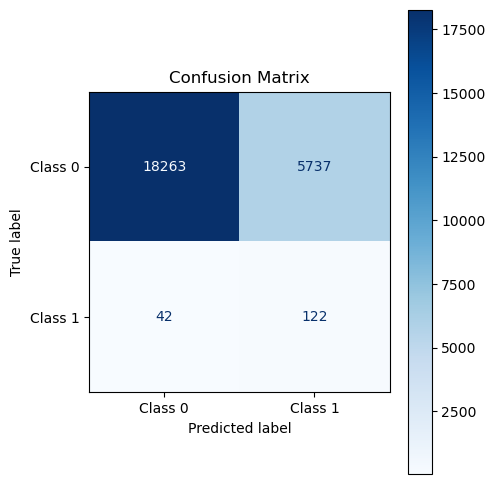

In [44]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced',penalty=None, random_state=42)

evaluator = ModelEvaluator(
    model=logreg,
    average='macro',   # or 'binary' for binary classification
    display_labels=['Class 0', 'Class 1']  # customize based on your labels
)

logreg = evaluator.fit_and_evaluate(X_non_embed_train, y_train, X_non_embed_val, y_val)

In [45]:
scores_non_embed_macro = cross_val_score(logreg, X_non_embed_train, y_train, cv=kfold, scoring='recall_macro')
scores_non_embed_acc = cross_val_score(logreg, X_non_embed_train, y_train, cv=kfold, scoring='accuracy')
scores_non_embed_f1 = cross_val_score(logreg, X_non_embed_train, y_train, cv=kfold, scoring='f1_macro')

In [47]:
print(f'CV scores on non embedding are:')
print(f'recall:{np.mean(scores_non_embed_macro)}')
print(f'acc:{np.mean(scores_non_embed_acc)}')
print(f'f1:{np.mean(scores_non_embed_f1)}')

CV scores on non embedding are:
recall:0.6151204875864801
acc:0.7884293053742734
f1:0.45497903953806634


check review embeddings only, check summary embedding only, check non feature review embedding cols
review 50, summary 10
